In [ ]:
!pip install split-folders

In [3]:
# import splitfolders
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from google.colab import drive

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATASET_DIR = "/content/drive/MyDrive/AAI_Dataset/CCMT Dataset"

In [ ]:
# Split folder into train, test and validation set.
splitfolders.ratio('/content/drive/MyDrive/AAI_Dataset/CCMT Dataset/', output="/content/drive/MyDrive/AAI_Dataset/CCMT Dataset/", seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 14894 files [15:11, 16.34 files/s]


In [6]:
train_dir = DATASET_DIR + "/train"
valid_dir = DATASET_DIR + "/valid"
diseases = os.listdir(train_dir)

diseases = [item for item in diseases]

print(diseases)

['bacterial blight', 'septoria leaf spot', 'verticulium wilt', 'leaf curl', 'streak virus', 'grasshoper', 'fall armyworm', 'green mite', 'brown spot', 'red rust', 'gumosis', 'anthracnose']


In [7]:
print(f"Total classes are: {len(diseases)}")

Total classes are: 12


In [8]:
nums = {disease: len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases}

# Converting the nums dictionary to pandas DataFrame with plant name as index and number of images as column
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])

img_per_class

,No. of images
bacterial blight,2099
septoria leaf spot,2194
verticulium wilt,618
leaf curl,414
streak virus,781
grasshoper,538
fall armyworm,228
green mite,812
brown spot,1184
red rust,1345


In [9]:
sum([len(os.listdir(os.path.join(train_dir, disease))) for disease in diseases])

11909

<ipython-input-10-fb203da1fe06>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=img_per_class, x=img_per_class.index, palette="viridis")


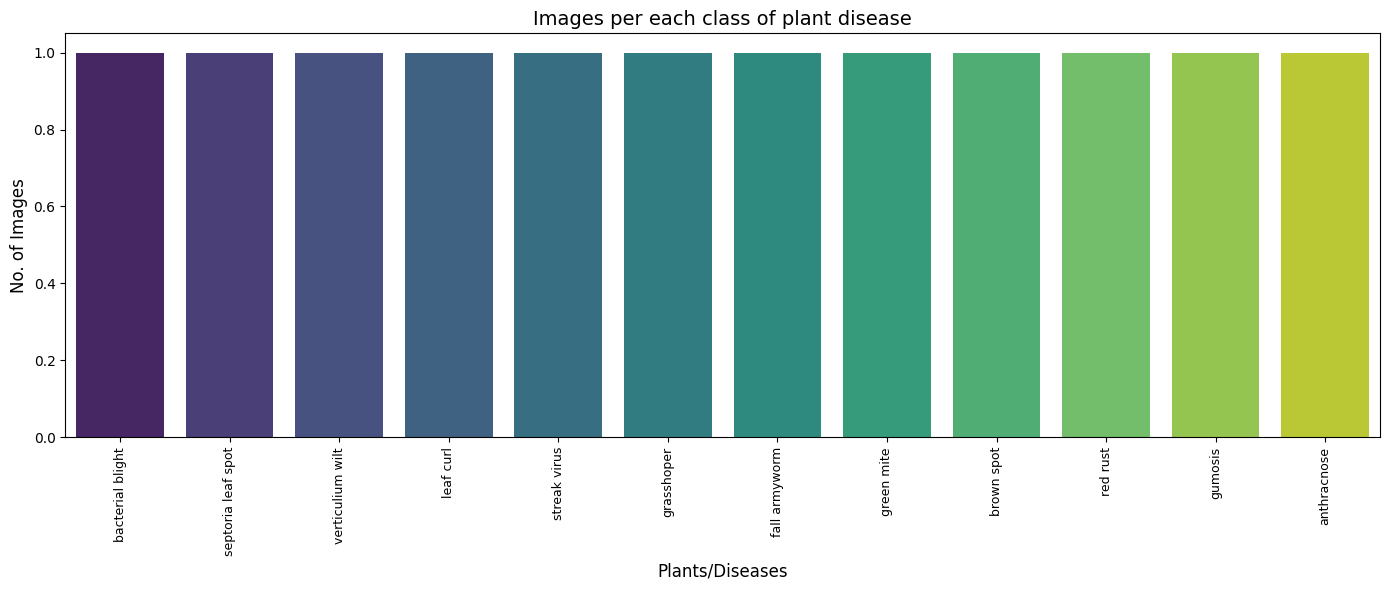

In [10]:
plt.figure(figsize=(14, 6))
sns.countplot(data=img_per_class, x=img_per_class.index, palette="viridis")
plt.xlabel('Plants/Diseases', fontsize=12)
plt.ylabel('No. of Images', fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.title('Images per each class of plant disease', fontsize=14)
plt.tight_layout()
plt.show()

In [11]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
def is_valid_file(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception as e:
        return False

In [13]:
batch_size=32

In [14]:
train_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/CCMT Dataset/train', transform=train_transforms, is_valid_file=is_valid_file)
val_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/CCMT Dataset/val', transform=val_transforms, is_valid_file=is_valid_file)
test_dataset = ImageFolder(root='/content/drive/MyDrive/AAI_Dataset/CCMT Dataset/test', transform=val_transforms, is_valid_file=is_valid_file)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


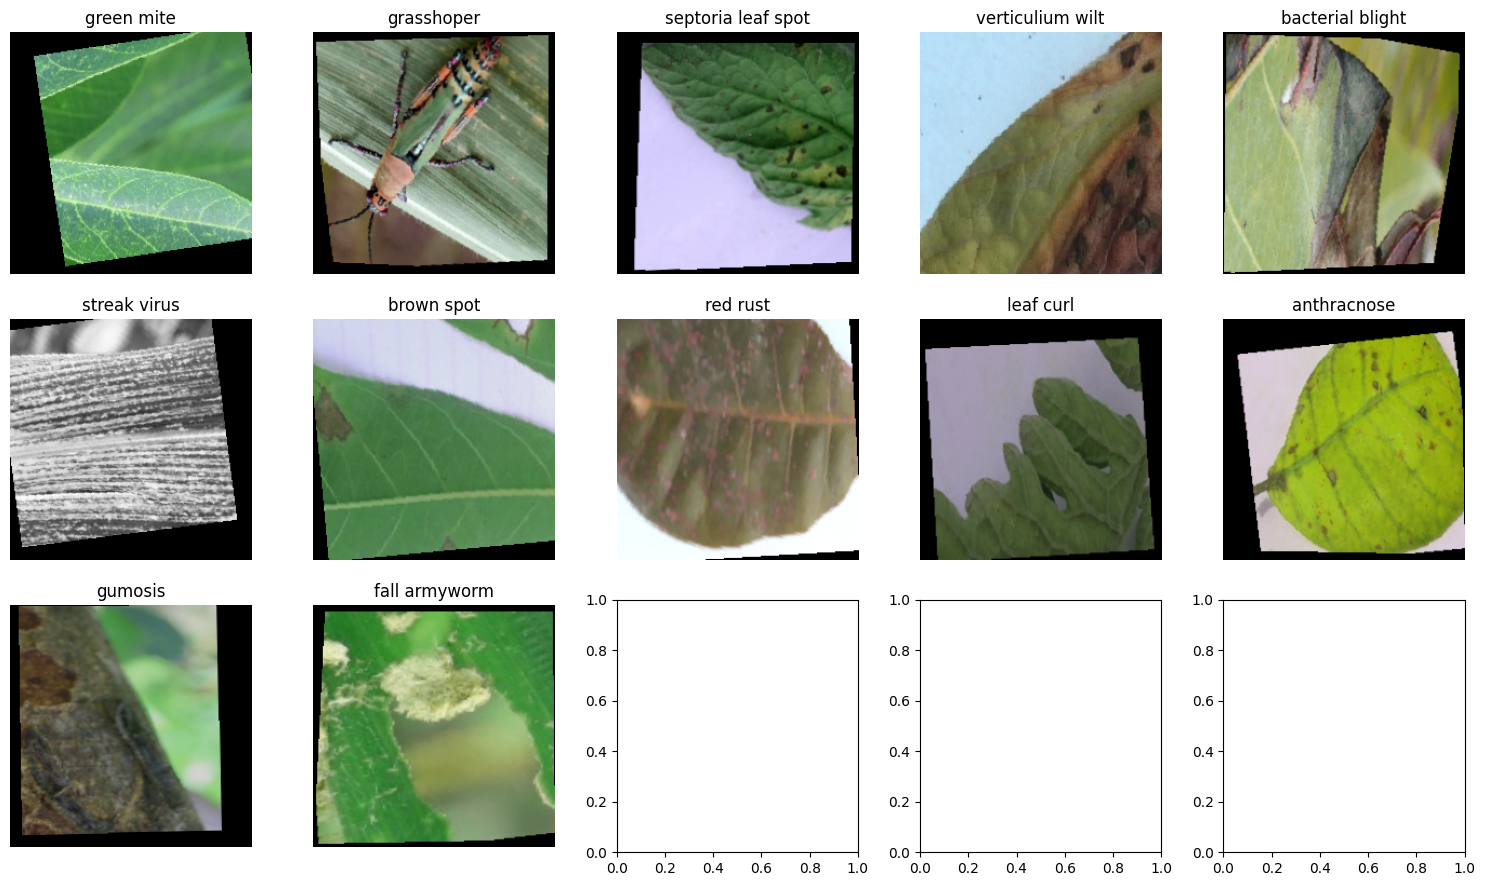

In [16]:
unique_classes = set()
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_classes = len(class_to_idx)
num_rows = math.ceil(num_classes/5)
num_cols = min(5, num_classes)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 3))

row_index = 0
col_index = 0

for images, labels in train_loader:
    images = [img for img in images if img is not None]
    labels = [label for label, img in zip(labels, images) if img is not None]
    images = torch.stack(images)
    for image, label in zip(images, labels):

        class_name = idx_to_class[label.item()]
        try:
          if class_name not in unique_classes:
              unique_classes.add(class_name)
              ax = axes[row_index, col_index]
              img = image.numpy().transpose((1, 2, 0))
              mean = np.array([0.485, 0.456, 0.406])
              std = np.array([0.229, 0.224, 0.225])
              img = std * img + mean
              img = np.clip(img, 0, 1)

              ax.imshow(img)
              ax.set_title(class_name)
              ax.axis('off')

              col_index += 1
              if col_index == num_cols:
                  col_index = 0
                  row_index += 1
        except (OSError,Exception) as e:
          continue

        if len(unique_classes) == num_classes:
            break
    if len(unique_classes) == num_classes:
        break

plt.tight_layout()
plt.show()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, len(train_dataset.classes))
)
model.to(device)

Device: cpu


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [19]:
TENSORBOARD_SUMMARY_PATH=f'{DATASET_DIR}/CCMT_PlantVillage'
writer = SummaryWriter(TENSORBOARD_SUMMARY_PATH)

In [20]:
BEST_MODEL_PATH='/content/drive/MyDrive/AAI_Dataset/ResNet18_CCMT.pth'

In [21]:
early_stopping_patience = 5
epochs_no_improve = 0
val_loss_min = np.Inf

In [22]:
def train_model(num_epochs):
    global epochs_no_improve
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        # Train the model
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        writer.add_scalar('Training loss', epoch_loss, epoch)
        writer.add_scalar('Training accuracy', epoch_acc, epoch)

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / val_total
        val_accuracy = val_correct / val_total
        writer.add_scalar('Validation loss', val_loss, epoch)
        writer.add_scalar('Validation accuracy', val_accuracy, epoch)

        scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), BEST_MODEL_PATH)
        else:
            epochs_no_improve += 1

        if epochs_no_improve == early_stopping_patience:
            print('Early stopping initiated...')
            break

In [23]:
num_epochs = 10
train_model(num_epochs)

Epoch [1/10], Train Loss: 1.2212, Train Acc: 0.5878, Val Loss: 0.4465, Val Acc: 0.8394
Epoch [2/10], Train Loss: 0.7179, Train Acc: 0.7417, Val Loss: 0.3558, Val Acc: 0.8549
Epoch [3/10], Train Loss: 0.6280, Train Acc: 0.7789, Val Loss: 0.2971, Val Acc: 0.8826
Epoch [4/10], Train Loss: 0.5734, Train Acc: 0.7902, Val Loss: 0.3015, Val Acc: 0.8941
Epoch [5/10], Train Loss: 0.5318, Train Acc: 0.8097, Val Loss: 0.2818, Val Acc: 0.8968
Epoch [6/10], Train Loss: 0.5144, Train Acc: 0.8104, Val Loss: 0.3127, Val Acc: 0.8785
Epoch [7/10], Train Loss: 0.4930, Train Acc: 0.8238, Val Loss: 0.2701, Val Acc: 0.9049
Epoch [8/10], Train Loss: 0.4586, Train Acc: 0.8368, Val Loss: 0.2324, Val Acc: 0.9150
Epoch [9/10], Train Loss: 0.4436, Train Acc: 0.8358, Val Loss: 0.2476, Val Acc: 0.9096
Epoch [10/10], Train Loss: 0.4303, Train Acc: 0.8433, Val Loss: 0.2341, Val Acc: 0.9123


In [24]:
# Model evaluation
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
test_correct = 0
test_total = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = test_correct / test_total
print(f'\n\nTest Accuracy: {test_accuracy:.4f}')

writer.close()



Test Accuracy: 0.8566


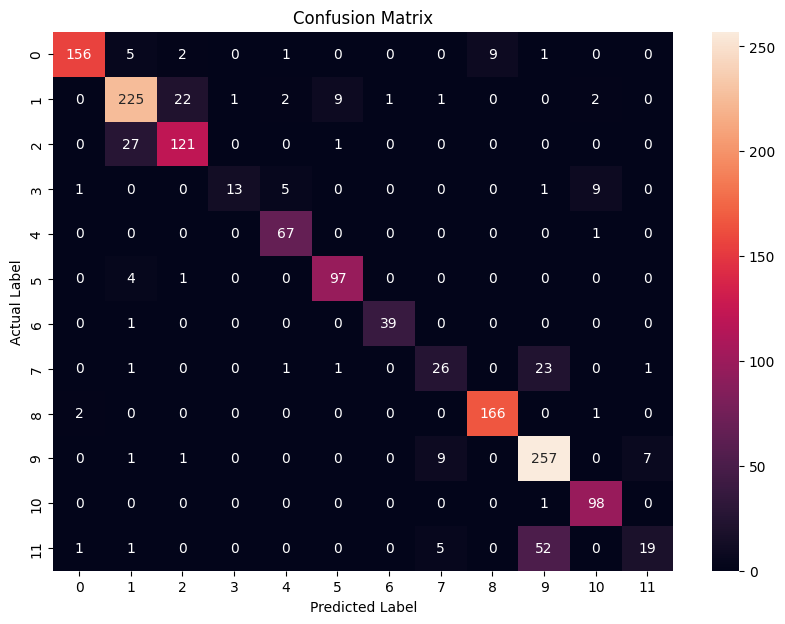

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       174
           1       0.85      0.86      0.85       263
           2       0.82      0.81      0.82       149
           3       0.93      0.45      0.60        29
           4       0.88      0.99      0.93        68
           5       0.90      0.95      0.92       102
           6       0.97      0.97      0.97        40
           7       0.63      0.49      0.55        53
           8       0.95      0.98      0.97       169
           9       0.77      0.93      0.84       275
          10       0.88      0.99      0.93        99
          11       0.70      0.24      0.36        78

    accuracy                           0.86      1499
   macro avg       0.86      0.80      0.81      1499
weighted avg       0.85      0.86      0.85      1499



In [25]:
conf_matrix = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

class_report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(class_report)

In [26]:
%load_ext tensorboard
%tensorboard
%tensorboard --logdir {TENSORBOARD_SUMMARY_PATH}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2024-03-24 07:18:20.214612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 07:18:20.214788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 07:18:20.350840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 07:18:23.211124: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for de

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2024-03-24 07:18:30.940901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 07:18:30.940982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 07:18:30.942612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 07:18:32.220461: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--load_f

In [27]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

event_acc = EventAccumulator(TENSORBOARD_SUMMARY_PATH)
event_acc.Reload()

train_loss = [event.value for event in event_acc.Scalars('Training loss')]
train_accuracy = [event.value for event in event_acc.Scalars('Training accuracy')]
val_loss = [event.value for event in event_acc.Scalars('Validation loss')]
val_accuracy = [event.value for event in event_acc.Scalars('Validation accuracy')]

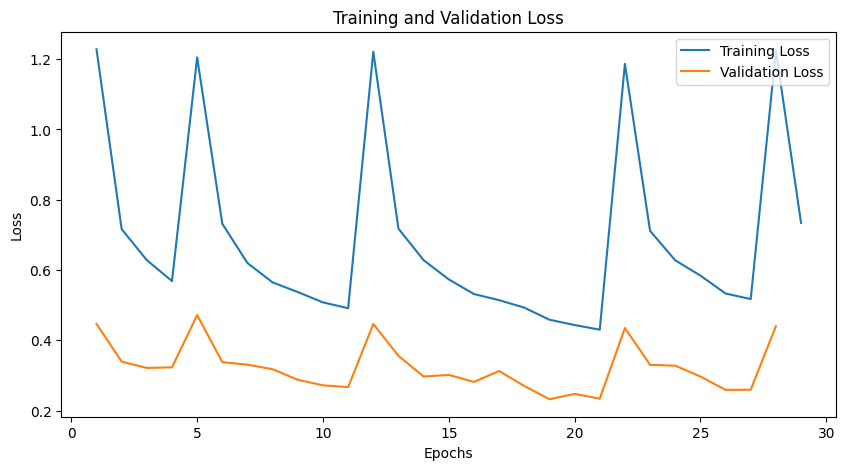

In [28]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

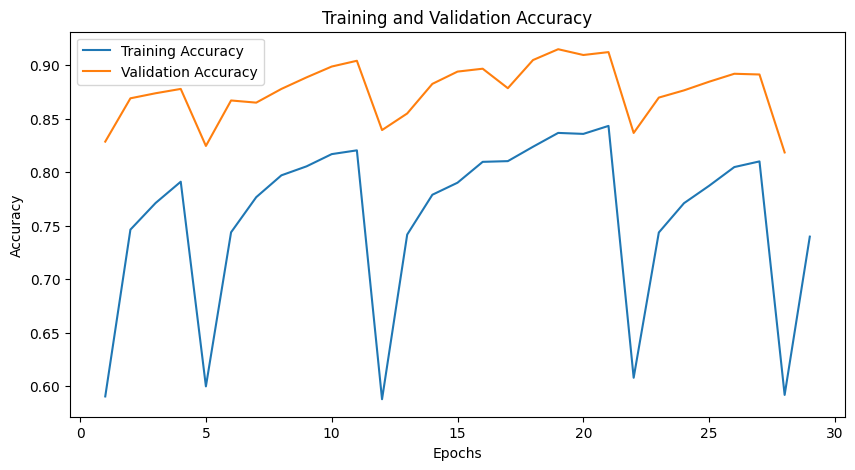

In [29]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(train_accuracy) + 1), y=train_accuracy, label='Training Accuracy')
sns.lineplot(x=range(1, len(val_accuracy) + 1), y=val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [30]:
def extract_features(loader, model, device):
    features = []
    targets = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return np.array(features), np.array(targets)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


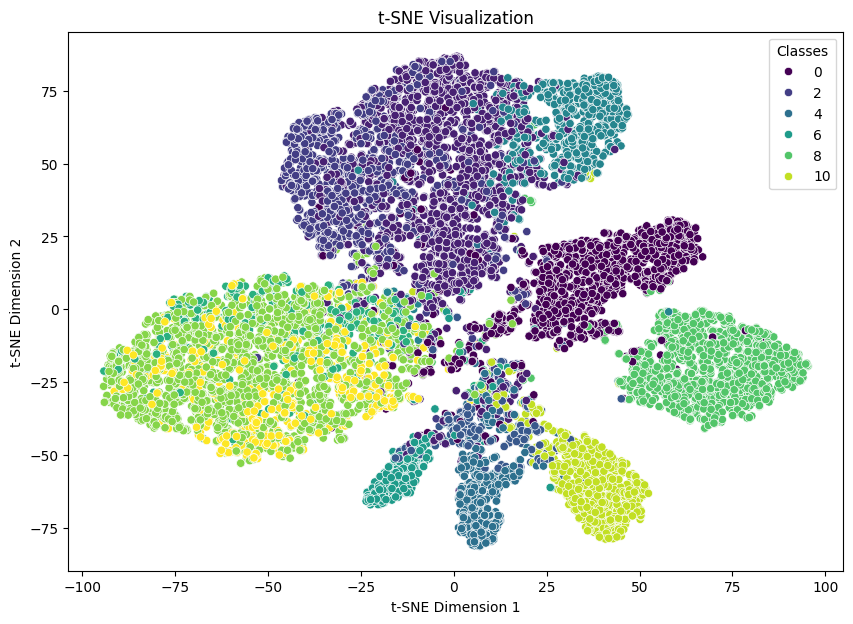

In [31]:
train_features, train_targets = extract_features(train_loader, model, device)
val_features, val_targets = extract_features(val_loader, model, device)

all_features = np.concatenate((train_features, val_features), axis=0)
all_targets = np.concatenate((train_targets, val_targets), axis=0)

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(all_features)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=all_targets, palette='viridis')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Classes')
plt.show()